## 电信客户流失生存分析报告 ##

**第一部分：重构项目代码**

**概述**

**生存分析（Survival Analysis）是一种用于估计事件发生时间的统计方法。本项目以电信客户流失（Churn）为分析对象，旨在预测客户的在网时长、分析影响流失的因素，并估算客户生命周期价值（CLTV）。**


**1. 数据预处理**

本项目使用了 Telco Customer Churn 数据集。通过 PySpark 进行数据加载与清洗，主要处理步骤包括：

将 Churn 字段转化为二元变量（Yes → 1，No → 0）。

筛选合同类型为“Month-to-month”，且拥有互联网服务的客户。

处理 TotalCharges 字段中的空值。



In [42]:
# 1. 环境配置与数据加载


from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter, LogLogisticAFTFitter

spark = SparkSession.builder \
    .appName("Survival Analysis") \
    .config("spark.sql.warehouse.dir", "/tmp") \
    .getOrCreate()

DATA_PATH = "data"  

schema = StructType([
    StructField("customerID", StringType()),
    StructField("gender", StringType()),
    StructField("SeniorCitizen", IntegerType()),
    StructField("Partner", StringType()),
    StructField("Dependents", StringType()),
    StructField("tenure", IntegerType()),
    StructField("PhoneService", StringType()),
    StructField("MultipleLines", StringType()),
    StructField("InternetService", StringType()),
    StructField("OnlineSecurity", StringType()),
    StructField("OnlineBackup", StringType()),
    StructField("DeviceProtection", StringType()),
    StructField("TechSupport", StringType()),
    StructField("StreamingTV", StringType()),
    StructField("StreamingMovies", StringType()),
    StructField("Contract", StringType()),
    StructField("PaperlessBilling", StringType()),
    StructField("PaymentMethod", StringType()),
    StructField("MonthlyCharges", DoubleType()),
    StructField("TotalCharges", StringType()),  
    StructField("Churn", StringType())
])

# 读取CSV文件
bronze_df = spark.read.csv(
    f"{DATA_PATH}/Telco-Customer-Churn.csv",
    schema=schema,
    header=True
)

# 数据清洗与转换
silver_df = (bronze_df
    .withColumn("Churn", F.when(F.col("Churn") == "Yes", 1).otherwise(0))
    .withColumn("TotalCharges", F.when(F.length(F.col("TotalCharges")) == 0, None).otherwise(F.col("TotalCharges").cast(DoubleType())))  # 处理TotalCharges为空的问题
    .filter(F.col("Contract") == "Month-to-month")
    .filter(F.col("InternetService") != "No")
)

# 创建临时视图
silver_df.createOrReplaceTempView("silver_customers")

25/04/13 20:02:54 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


**2. Kaplan-Meier 生存曲线分析**

使用 Kaplan-Meier 方法对客户生存函数进行估计：

时间（T）：客户在网时长（以月为单位）

事件（E）：客户是否流失

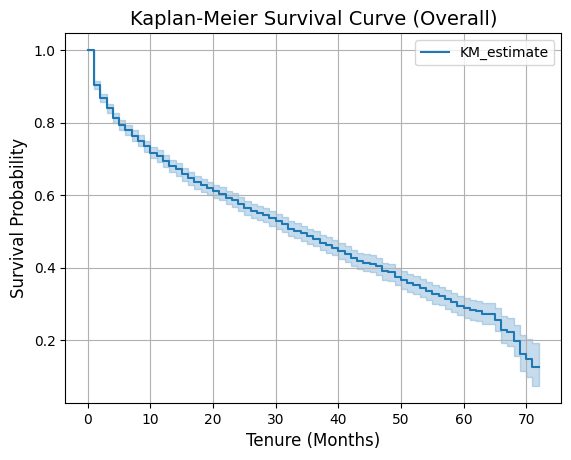

In [43]:
#2. Kaplan-Meier生存曲线分析

# 将数据转换为Pandas DataFrame
telco_pd = silver_df.toPandas()

# 初始化Kaplan-Meier模型
kmf = KaplanMeierFitter()

# 定义时间和事件列
T = telco_pd['tenure']
E = telco_pd['Churn'].astype(float)

# 拟合Kaplan-Meier模型
kmf.fit(T, event_observed=E)

# 绘制生存函数曲线
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve (Overall)', fontsize=14)
plt.ylabel('Survival Probability', fontsize=12)
plt.xlabel('Tenure (Months)', fontsize=12)
plt.grid(True)
plt.show()

从生存曲线可以看出，客户流失风险在最初 20 个月内较大，流失速度快，随后流失速度趋向平稳，在65个月左右的使用后又会断崖式下降。，70个月以后留存率仅剩10%左右。

**3. Cox 比例风险模型分析**

应用 Cox 比例风险模型（CoxPH）分析不同变量对客户流失风险的影响。

选择的协变量包括：

是否有家属（Dependents）

互联网服务类型（InternetService: DSL）

是否启用在线备份（OnlineBackup）

是否启用技术支持（TechSupport）

<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 3351
number of events observed = 1556
   partial log-likelihood = -11315.95
         time fit was run = 2025-04-13 20:36:07 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Dependents_Yes      -0.33      0.72      0.07           -0.47           -0.19                0.63                0.83
InternetService_DSL -0.22      0.80      0.06           -0.33           -0.10                0.72                0.90
OnlineBackup_Yes    -0.78      0.46      0.06           -0.89           -0.66                0.41                0.52
TechSupport_Yes     -0.64      0.53      0.08           -0.79           -0.49                0.46                0.61

                     cmp to      z      p  -log2(p)
covariate                                          
Dependents_Yes         0.00  -4.64 <0.005     18.12
InternetService_DSL    0.00  -3.68 <0.005     12.07
OnlineBackup_Yes       0.00 -13.13 <0.005    128.37
TechSupport_Yes        0.00  -8.48 <0.005     55.36
---
Concordance = 0.64
Partial AIC = 22639.90
log-likelihood ratio test = 337.77 on 4 df
-log2(p) of ll-ratio test = 236.24

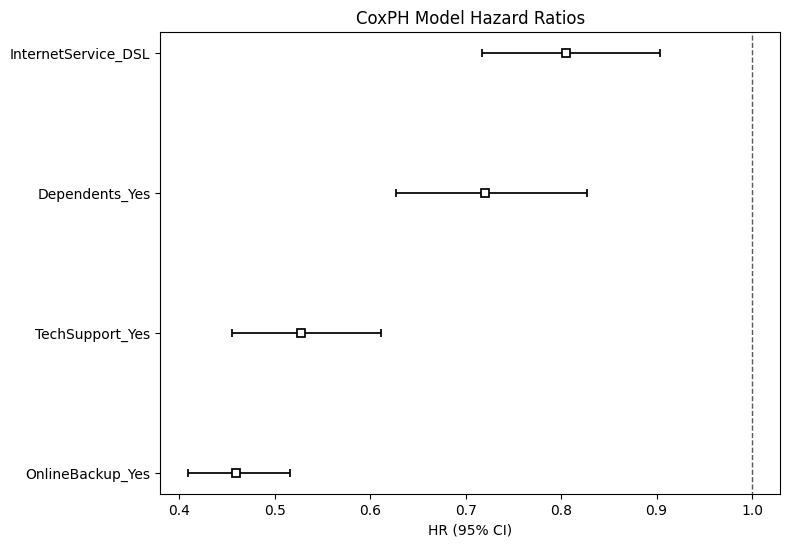

In [48]:
#3. Cox比例风险模型

# 选择部分协变量
covariates = ['Dependents_Yes', 'InternetService_DSL', 
              'OnlineBackup_Yes', 'TechSupport_Yes']

# 对分类变量进行One-Hot编码
encoded_df = pd.get_dummies(telco_pd, columns=['Dependents', 'InternetService', 'OnlineBackup', 'TechSupport'])

# 初始化并拟合Cox比例风险模型
cph = CoxPHFitter()
cph.fit(encoded_df[covariates + ['tenure', 'Churn']], 
        duration_col='tenure',
        event_col='Churn')

# 输出Cox模型摘要
cph.print_summary()

plt.figure(figsize=(8,6))
cph.plot(hazard_ratios=True)
plt.title('CoxPH Model Hazard Ratios')
plt.show()

在cox比例风险模型中，

coef：系数（Coefficient），如果是负的，说明这个特征降低了流失风险。

exp(coef)：风险比（Hazard Ratio, HR）

HR < 1：风险下降（客户更容易留存）

HR > 1：风险上升（客户更容易流失）。

对于选择的协变量：

是否有家属（Dependents_Yes）：有家属的客户，其流失风险比没有家属的客户低28%。

使用DSL互联网服务（InternetService_DSL）：使用DSL网络服务的客户流失风险比其他网络服务低20%。

启用在线备份（OnlineBackup_Yes）：启用了在线备份服务的客户流失风险降低54%。

启用技术支持（TechSupport_Yes）：有技术支持服务的客户流失风险下降47%。

综上所述，启用在线备份和启用技术支持更可以显著地提升客户留存概率

**4. 加速失效时间（AFT）模型分析**

使用 Log-Logistic 加速失效时间（AFT）模型，直接建模客户流失的时间。

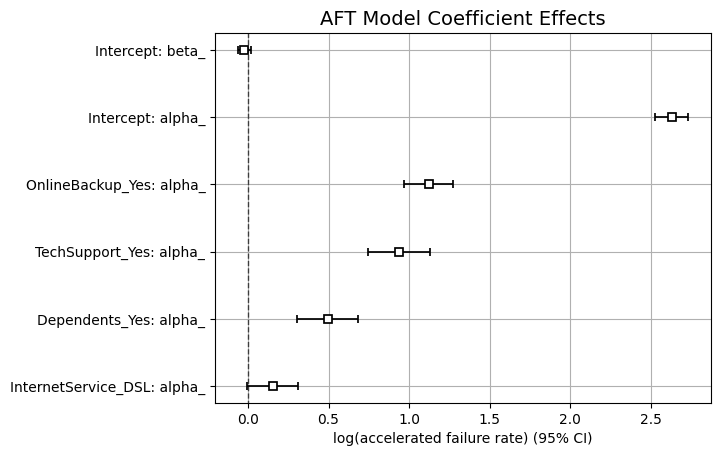

In [45]:
#4. 加速失效时间（AFT）模型分析

# 初始化Log-Logistic AFT模型
aft = LogLogisticAFTFitter()

# 拟合AFT模型
aft.fit(encoded_df[covariates + ['tenure', 'Churn']],
        duration_col='tenure',
        event_col='Churn')

# 绘制AFT模型系数影响
aft.plot()
plt.title('AFT Model Coefficient Effects', fontsize=14)
plt.grid(True)
plt.show()

通过Log-Logistic AFT模型分析：

是否有家属（Dependents_Yes）：系数为正，表明有家属的客户在网时间更长。

使用DSL互联网服务（InternetService_DSL）：系数为正，使用DSL服务的客户在网时间较长。

启用在线备份（OnlineBackup_Yes）：系数显著为正，启用在线备份服务能明显延长客户生命周期。

启用技术支持（TechSupport_Yes）：系数显著为正，提供技术支持服务可以有效提升客户留存时间。

总体来看，与Cox比例风险模型的结论一致，在线备份和技术支持是影响客户生命周期的关键因素。


**5. 客户生命周期价值（CLTV）预测**

训练Cox模型，并基于 Cox 模型预测的生存概率，计算客户生命周期价值（CLTV）。假设条件如下：

月均收入：30美元

年折现率：10%

客户特征可以自定义

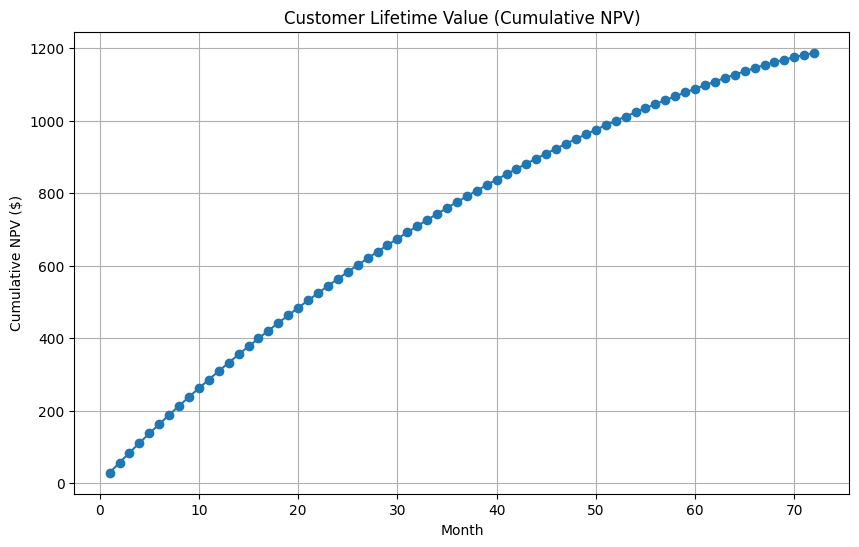

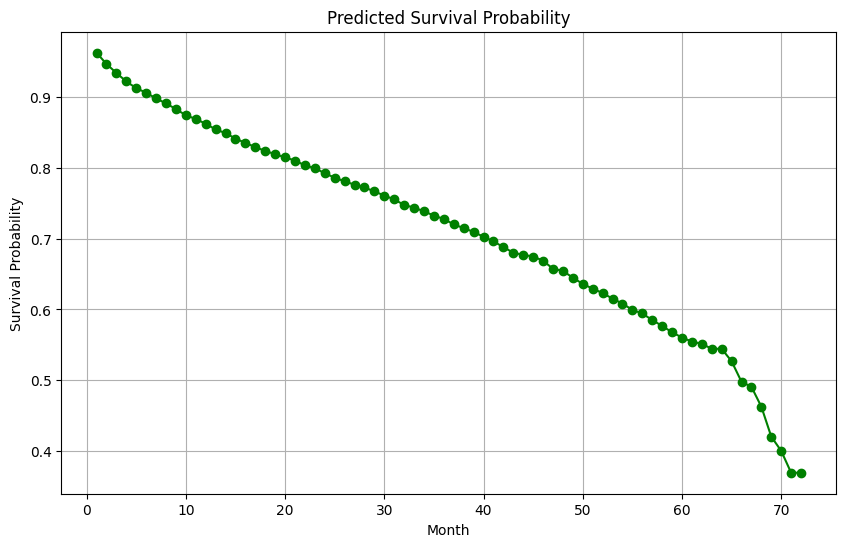

In [49]:
#5. 客户生命周期价值（CLTV）分析
silver_df = pd.read_csv('./data/silver_monthly_customers.csv')

# One-Hot编码用于模型训练的分类变量
encode_cols = ['dependents', 'internetservice', 'onlinebackup', 'techsupport', 'paperlessbilling']

encoded_df = pd.get_dummies(silver_df, columns=encode_cols, prefix=encode_cols, drop_first=False)

# 选择用于生存模型的特征
survival_df = encoded_df[['churn', 'tenure', 'dependents_Yes', 'internetservice_DSL', 'onlinebackup_Yes', 'techsupport_Yes']]



# 初始化并训练Cox比例风险模型
cph = CoxPHFitter(alpha=0.05)
cph.fit(survival_df, duration_col='tenure', event_col='churn')

# 设置要预测的客户特征
# 0表示没有这个属性，1表示有这个属性
customer_features = {
    'dependents_Yes': 1,
    'internetservice_DSL': 1,
    'onlinebackup_Yes': 1,
    'techsupport_Yes': 0,
    
}

# 组装成DataFrame
X_input = pd.DataFrame([{
    'dependents_Yes': customer_features.get('dependents_Yes', 0),
    'internetservice_DSL': customer_features.get('internetservice_DSL', 0),
    'onlinebackup_Yes': customer_features.get('onlinebackup_Yes', 0),
    'techsupport_Yes': customer_features.get('techsupport_Yes', 0)
}])

# 预测未来生存概率（按月）
survival_probs = cph.predict_survival_function(X_input)


# 定义参数
monthly_profit = 30             # 每月利润（假设）
annual_discount_rate = 0.10     # 年贴现率10%
monthly_discount_rate = annual_discount_rate / 12

# 计算每个月的贴现利润
discounted_profits = survival_probs.iloc[:,0] * monthly_profit / (1 + monthly_discount_rate) ** (survival_probs.index)

# 计算累计NPV（净现值）
cumulative_npv = discounted_profits.cumsum()


#可视化
plt.figure(figsize=(10,6))
plt.plot(cumulative_npv.index, cumulative_npv.values, marker='o')
plt.title('Customer Lifetime Value (Cumulative NPV)')
plt.xlabel('Month')
plt.ylabel('Cumulative NPV ($)')
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(survival_probs.index, survival_probs.iloc[:,0], marker='o', color='green')
plt.title('Predicted Survival Probability')
plt.xlabel('Month')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

**6. 总结**

Kaplan-Meier 分析显示，客户在初期（20个月内）流失风险最高。

Cox 模型确认了在线备份和技术支持对客户留存的重要性。

AFT 模型进一步验证了这些变量的显著性。

预测的 CLTV 为公司提供了有价值的客户管理和定价决策依据。






—————————————————————————————————————————————————————————————————————————————————————————————————